![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/healthcare-nlp/09.2.Spark_OCR_Deidentification.ipynb)

## Blogposts and videos

- [Text Detection in Spark OCR](https://medium.com/spark-nlp/text-detection-in-spark-ocr-dcd8002bdc97)

- [Table Detection & Extraction in Spark OCR](https://medium.com/spark-nlp/table-detection-extraction-in-spark-ocr-50765c6cedc9)

- [Extract Tabular Data from PDF in Spark OCR](https://medium.com/spark-nlp/extract-tabular-data-from-pdf-in-spark-ocr-b02136bc0fcb)

- [Signature Detection in Spark OCR](https://medium.com/spark-nlp/signature-detection-in-spark-ocr-32f9e6f91e3c)

- [GPU image pre-processing in Spark OCR](https://medium.com/spark-nlp/gpu-image-pre-processing-in-spark-ocr-3-1-0-6fc27560a9bb)

- [How to Setup Spark OCR on UBUNTU - Video](https://www.youtube.com/watch?v=cmt4WIcL0nI)


**More examples here**

https://github.com/JohnSnowLabs/spark-ocr-workshop

For get the trial license please go to:

https://www.johnsnowlabs.com/install/

### Colab Setup

In [ ]:
# Install the johnsnowlabs library to access Spark-OCR and Spark-NLP for Healthcare, Finance, and Legal.
!pip install -q johnsnowlabs

In [ ]:
 from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

In [ ]:
from johnsnowlabs import nlp, visual, medical

# After uploading your license run this to install all licensed Python Wheels and pre-download Jars the Spark Session JVM
nlp.install(refresh_install=True, visual=True)

In [4]:
# Automatically load license data and start a session with all jars user has access to
spark = nlp.start(visual=True)

👌 Detected license file /content/spark_nlp_for_healthcare_spark_ocr_9005.json
👌 Launched cpu optimized session with with: 🚀Spark-NLP==5.3.1, 💊Spark-Healthcare==5.3.0, 🕶Spark-OCR==5.3.0, running on ⚡ PySpark==3.4.0


In [5]:
import pandas as pd
import pkg_resources
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F
from sparkocr.transformers import *
from pyspark.ml import PipelineModel
from sparkocr.utils import display_image, display_images, display_table, display_tables, to_pil_image
from sparkocr.metrics import score
from sparkocr.enums import *
from sparknlp.base import *
from sparknlp_jsl.annotator import *
from sparknlp.annotator import *

## Dicom Image Deidentifier

**Define deidentification pipeline**

In [6]:
def deidentification_nlp_pipeline(input_column, prefix = ""):
    document_assembler = nlp.DocumentAssembler() \
        .setInputCol(input_column) \
        .setOutputCol(prefix + "document")

    # Sentence Detector annotator, processes various sentences per line
    sentence_detector = nlp.SentenceDetector() \
        .setInputCols([prefix + "document"]) \
        .setOutputCol(prefix + "sentence")

    tokenizer = nlp.Tokenizer() \
        .setInputCols([prefix + "sentence"]) \
        .setOutputCol(prefix + "token")

    # Clinical word embeddings
    word_embeddings = nlp.WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token"]) \
        .setOutputCol(prefix + "embeddings")

    # NER model trained on i2b2 (sampled from MIMIC) dataset
    clinical_ner = medical.NerModel.pretrained("ner_deid_large", "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "embeddings"]) \
        .setOutputCol(prefix + "ner")

    custom_ner_converter = medical.NerConverterInternal() \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "ner"]) \
        .setOutputCol(prefix + "ner_chunk") \
        .setWhiteList(['NAME', 'AGE', 'CONTACT', 'LOCATION', 'PROFESSION', 'PERSON', 'DATE'])

    nlp_pipeline = nlp.Pipeline(stages=[
            document_assembler,
            sentence_detector,
            tokenizer,
            word_embeddings,
            clinical_ner,
            custom_ner_converter
        ])
    empty_data = spark.createDataFrame([[""]]).toDF(input_column)
    nlp_model = nlp_pipeline.fit(empty_data)
    return nlp_model

**Define OCR transformers and pipeline**

In [7]:
# Read dicom as image
dicom_to_image = visual.DicomToImage() \
    .setInputCol("content") \
    .setOutputCol("image_raw") \
    .setMetadataCol("metadata") \
    .setDeIdentifyMetadata(True)

adaptive_thresholding = visual.ImageAdaptiveThresholding() \
    .setInputCol("image_raw") \
    .setOutputCol("corrected_image") \
    .setBlockSize(47) \
    .setOffset(4) \
    .setKeepInput(True)

# Extract text from image
ocr = visual.ImageToText() \
    .setInputCol("corrected_image") \
    .setOutputCol("text")

# Found coordinates of sensitive data
position_finder = visual.PositionFinder() \
    .setInputCols("ner_chunk") \
    .setOutputCol("coordinates") \
    .setPageMatrixCol("positions")

# Found sensitive data using DeIdentificationModel
deidentification_rules = medical.DeIdentificationModel.pretrained("deidentify_rb_no_regex", "en", "clinical/models") \
    .setInputCols(["metadata_sentence", "metadata_token", "metadata_ner_chunk"]) \
    .setOutputCol("deidentified_metadata_raw")

finisher = nlp.Finisher() \
    .setInputCols(["deidentified_metadata_raw"]) \
    .setOutputCols("deidentified_metadata") \
    .setOutputAsArray(False) \
    .setValueSplitSymbol("") \
    .setAnnotationSplitSymbol("")

# Draw filled rectangle for hide sensitive data
drawRegions = visual.ImageDrawRegions()  \
    .setInputCol("image_raw")  \
    .setInputRegionsCol("coordinates")  \
    .setOutputCol("image_with_regions")  \
    .setFilledRect(True) \
    .setRectColor(visual.Color.black)

# Store image back to Dicom document
imageToDicom = visual.ImageToDicom() \
    .setInputCol("image_with_regions") \
    .setOutputCol("dicom")

# OCR pipeline
deid_pipeline = nlp.PipelineModel(stages=[
    dicom_to_image,
    adaptive_thresholding,
    ocr,
    deidentification_nlp_pipeline(input_column="text"),
    position_finder,
    drawRegions,
    #imageToDicom  # Commented for able to demonstrate intermidiate results before aggregation
])

deidentify_rb_no_regex download started this may take some time.
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_deid_large download started this may take some time.
[OK!]


In [8]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/dicom/deidentify-medical-2.dcm  -P content/dicom/
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/dicom/deidentify-brains-front-medical-3.dcm -P content/dicom/


file_path='content/dicom/*.dcm'
dicom_df = spark.read.format("binaryFile").load(file_path)
dicom_df.show()

+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|file:/content/con...|2024-03-25 15:42:...|900924|[00 00 00 00 00 0...|
+--------------------+--------------------+------+--------------------+




    Image #0:
    Origin: file:/content/content/dicom/deidentify-medical-2.dcm
    Resolution: 0 dpi
    Width: 914 px
    Height: 985 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


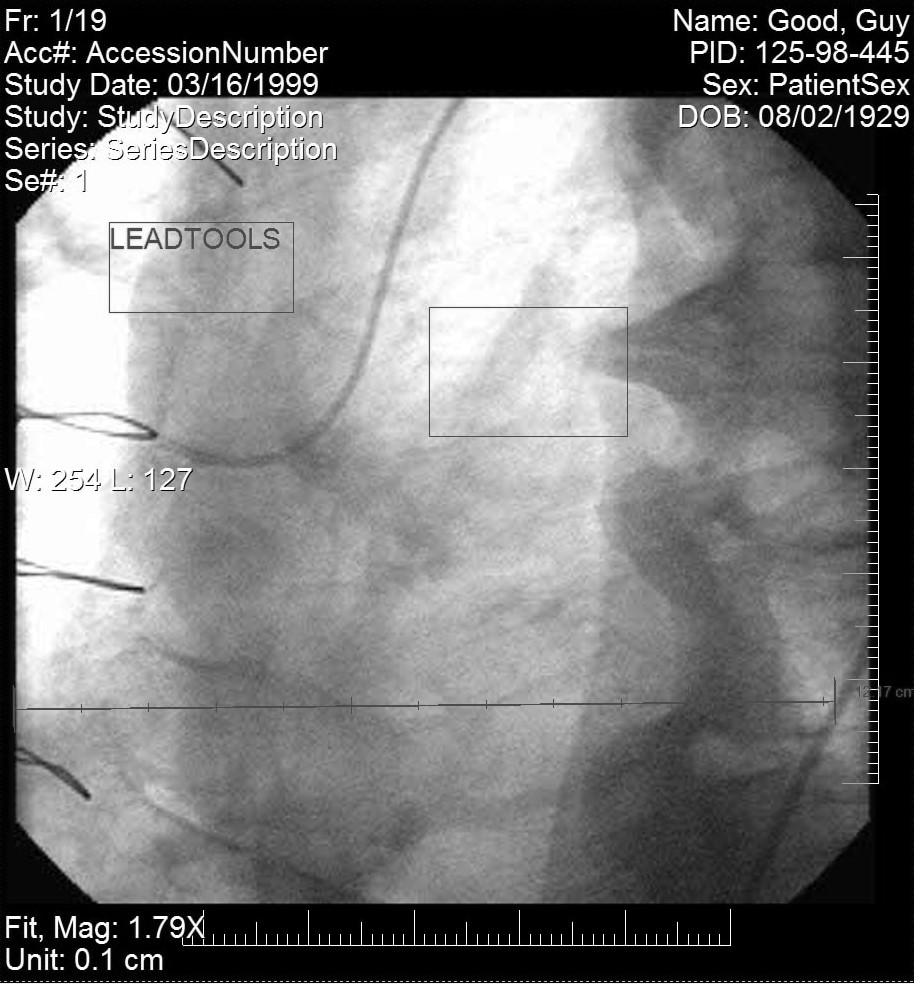

In [9]:
display_images(visual.DicomToImage().transform(dicom_df))

In [10]:
deid_results = deid_pipeline.transform(dicom_df).cache()

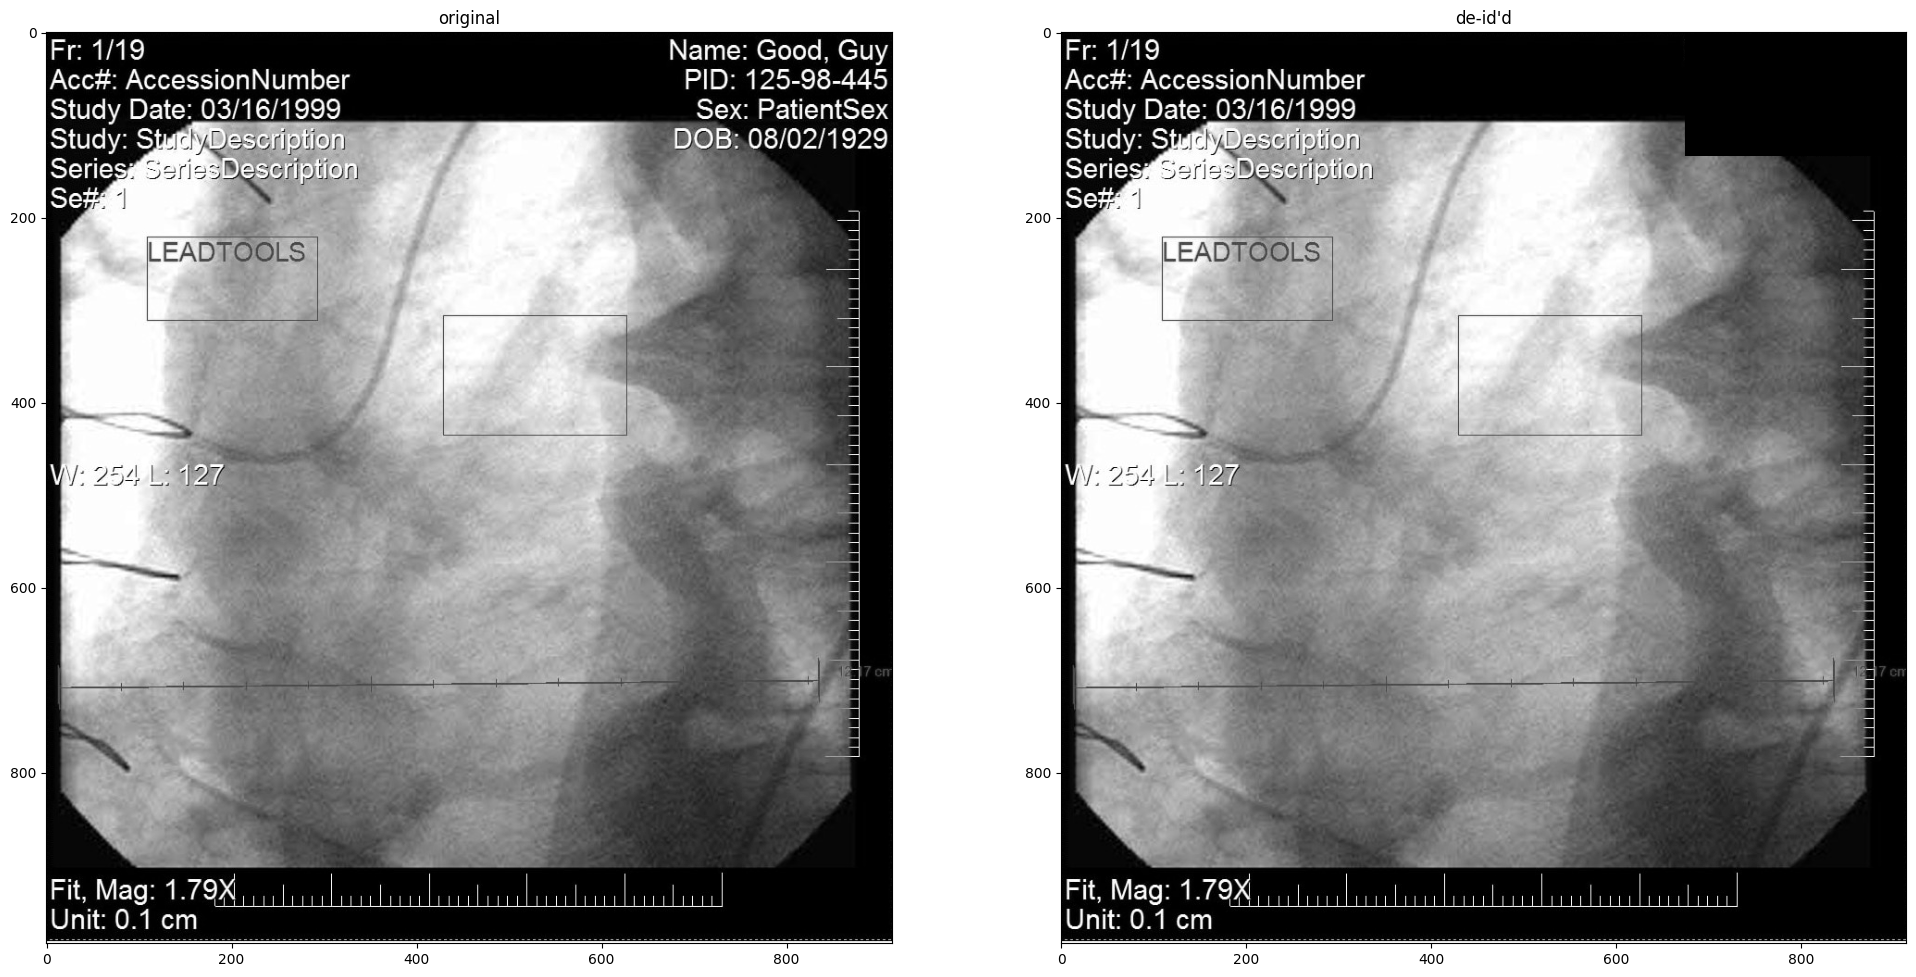

In [11]:
import matplotlib.pyplot as plt

for r in deid_results.select("image_raw", "image_with_regions").collect():
  img_orig = r.image_raw
  img_deid = r.image_with_regions

  img_pil_orig = to_pil_image(img_orig, img_orig.mode)
  img_pil_deid = to_pil_image(img_deid, img_deid.mode)

  plt.figure(figsize=(24,16))
  plt.subplot(1, 2, 1)
  plt.imshow(img_pil_orig, cmap='gray')
  plt.title('original')
  plt.subplot(1, 2, 2)
  plt.imshow(img_pil_deid, cmap='gray')
  plt.title("de-id'd")
  plt.show()

## PDF Document Deidentifier

**Define OCR transformers and pipeline**

In [12]:
# Read Pdf as image
pdf_to_image = visual.PdfToImage()\
    .setInputCol("content")\
    .setOutputCol("image_raw")\
    .setResolution(400)

# Extract text from image
ocr = visual.ImageToText() \
    .setInputCol("image_raw") \
    .setOutputCol("text") \
    .setIgnoreResolution(False) \
    .setPageIteratorLevel(PageIteratorLevel.SYMBOL) \
    .setPageSegMode(PageSegmentationMode.SPARSE_TEXT) \
    .setWithSpaces(True) \
    .setConfidenceThreshold(70)

hocr = visual.ImageToHocr() \
    .setInputCol("image_raw") \
    .setOutputCol("hocr") \
    .setIgnoreResolution(False) \
    .setOcrParams(["preserve_interword_spaces=0"])\
    .setPageIteratorLevel(PageIteratorLevel.SYMBOL)\
    .setPageSegMode(PageSegmentationMode.SPARSE_TEXT) \

# Found coordinates of sensitive data
position_finder = visual.PositionFinder() \
    .setInputCols("ner_chunk") \
    .setOutputCol("coordinates") \
    .setPageMatrixCol("positions")

# Draw filled rectangle for hide sensitive data
drawRegions = visual.ImageDrawRegions()  \
    .setInputCol("image_raw")  \
    .setInputRegionsCol("coordinates")  \
    .setOutputCol("image_with_regions")  \
    .setFilledRect(True) \
    .setRectColor(Color.black)

# OCR pipeline
deid_pipeline = nlp.PipelineModel(stages=[
    pdf_to_image,
    ocr,
    hocr,
    deidentification_nlp_pipeline(input_column="text"),
    position_finder,
    drawRegions
])

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_deid_large download started this may take some time.
[OK!]


In [13]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/ocr/MT_00.pdf -P content/deid/

In [14]:
image_path = pkg_resources.resource_filename('sparkocr', 'resources/ocr/images/p1.jpg')
image_df = spark.read.format("binaryFile").load(image_path)

In [15]:
file_path='content/deid/*.pdf'
pdfs = spark.read.format("binaryFile").load(file_path)
pdfs.show()

+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|file:/content/con...|2024-03-25 15:43:...|528022|[25 50 44 46 2D 3...|
+--------------------+--------------------+------+--------------------+



In [16]:
deid_results = deid_pipeline.transform(pdfs).cache()

In [17]:
deid_results.select("ner_chunk").show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ner_chunk                                                                     

In [18]:
deid_results.select('coordinates').show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|coordinates                                                                                                                                                                                                                                                                                                                                                                                     |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [19]:
!wget -q -O jsl_utils.py https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/utils/jsl_utils.py

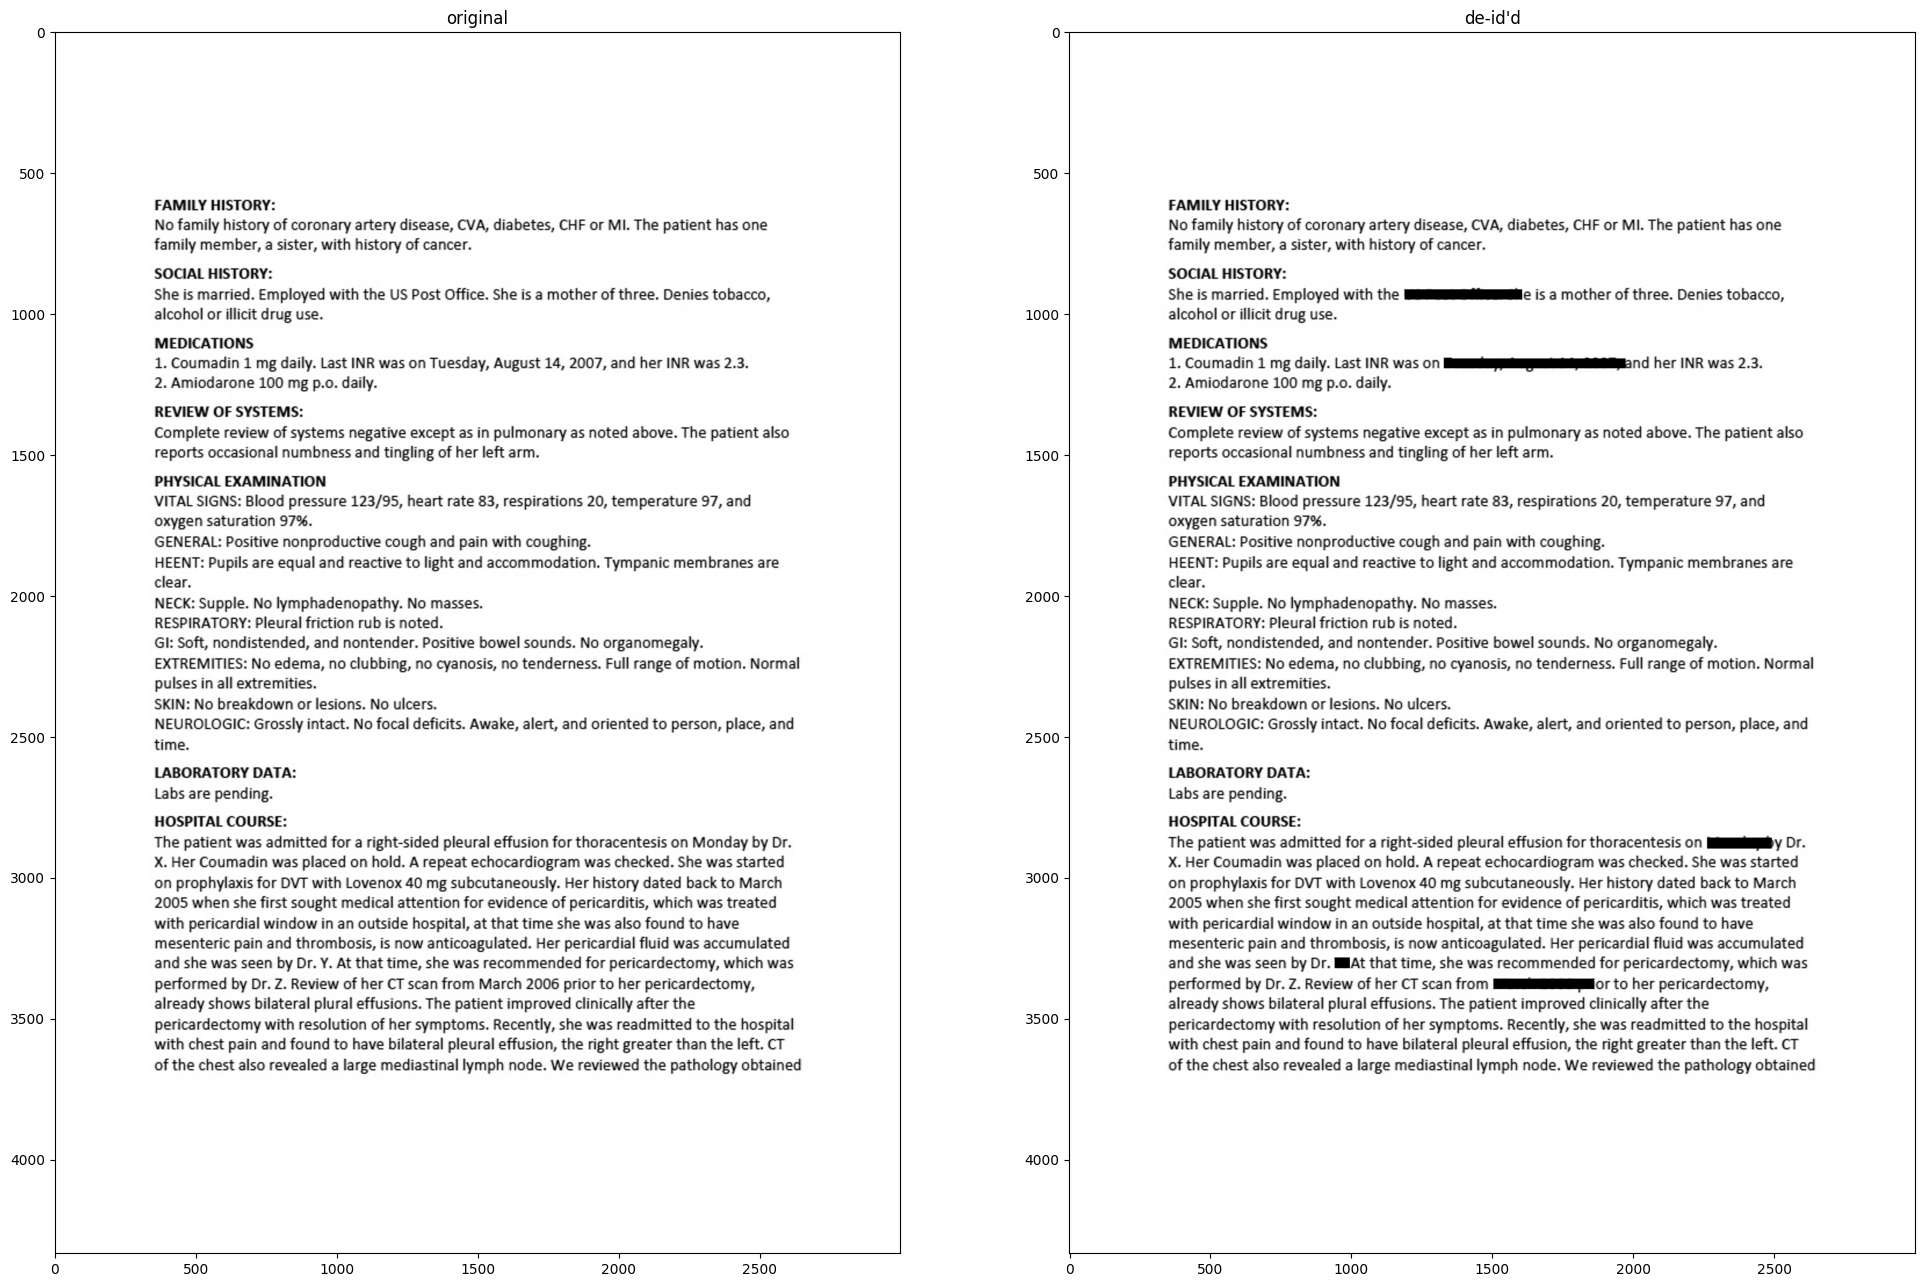

In [20]:
r = deid_results.select("image_raw", "image_with_regions").collect()[0]
img_orig = r.image_raw
img_deid = r.image_with_regions

img_pil_orig = to_pil_image(img_orig, img_orig.mode)
img_pil_deid = to_pil_image(img_deid, img_deid.mode)

plt.figure(figsize=(24,16))
plt.subplot(1, 2, 1)
plt.imshow(img_pil_orig, cmap='gray')
plt.title('original')
plt.subplot(1, 2, 2)
plt.imshow(img_pil_deid, cmap='gray')
plt.title("de-id'd")
plt.show()

In [ ]:
from jsl_utils import *

image_list = []

for row in range(0,1):
    text = deid_results.select('text').collect()[row][0]
    hocr =  deid_results.select('hocr').collect()[row][0]

    lmodel = LightPipeline(deidentification_nlp_pipeline('text'))
    ner_result = lmodel.fullAnnotate(text)
    ent_dict_list = [{'begin':x.begin, 'end':x.end, 'chunk':x.result, 'ner_label':x.metadata['entity'], 'sentence_id':x.metadata['sentence']} for x in ner_result[0]['ner_chunk']]

    coord_df = get_coordinates_frame(ent_dict_list, text, hocr)

    img_deid = deid_results.select('image_raw').collect()[row][0]
    img_pil_orig = to_pil_image(img_deid, img_deid.mode)
    img_pil_orig = img_pil_orig.convert("RGBA")

    img_deid = deid_results.select('image_raw').collect()[row][0]
    img_pil_deid = to_pil_image(img_deid, img_deid.mode)
    img_pil_deid = img_pil_deid.convert("RGBA")

    draw_outline(img_pil_deid, coord_df)

In [ ]:
highlighted_image_list = []  # append highlighted images

for row in range(0,1):
    text = deid_results.select('text').collect()[row][0]
    hocr =  deid_results.select('hocr').collect()[row][0]

    lmodel = LightPipeline(deidentification_nlp_pipeline('text'))
    ner_result = lmodel.fullAnnotate(text)
    ent_dict_list = [{'begin':x.begin, 'end':x.end, 'chunk':x.result, 'ner_label':x.metadata['entity'], 'sentence_id':x.metadata['sentence']} for x in ner_result[0]['ner_chunk']]

    coord_df = get_coordinates_frame(ent_dict_list, text, hocr)

    img_deid = deid_results.select('image_raw').collect()[row][0]
    img_pil_orig = to_pil_image(img_deid, img_deid.mode)
    img_pil_orig = img_pil_orig.convert("RGBA")

    img_deid = deid_results.select('image_raw').collect()[row][0]
    img_pil_deid = to_pil_image(img_deid, img_deid.mode)
    img_pil_deid = img_pil_deid.convert("RGBA")

    highlight(img_pil_deid, coord_df)